In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 12})
SaveFigs = False

from scipy import signal 
from scipy import stats
import itertools
import seaborn as sns
import statsmodels.api as sm
# import pywt

In [2]:
def ridge_error(x, y, r=0):
    ''' ridge_error(x, y, lambda):
    predicts y [n by m] from x [n by p] by ridge regression. 
    
    Returns:
    * fit error as a frac of variance (scalar), 
    * weight [p by m], 
    * prediction [N by m].
    '''
    
    # append to bottom of matrices to make ridge regression
    n = x.shape[0]
    p = x.shape[1]
    m = y.shape[1]
    x0 = np.block([[x, np.ones([n,1])]])
    x1 = np.block([[x, np.ones([n,1])], [r*np.eye(p), np.zeros([p,1])]])
    y1 = np.block([[y], [np.zeros((p,m))]])
    w, _, _, _ = np.linalg.lstsq(x1, y1, rcond=None)
    y_hat = x0@w
    return np.mean((y-y_hat)**2)/np.var(y), w, y_hat

#ridge_error(np.array([[1],[0]]),np.array([[2],[1]]),1e10)

In [3]:
class Bunch(dict):
    """A subclass of dictionary with an additional dot syntax."""

    def __init__(self, *args, **kwargs):
        super(Bunch, self).__init__(*args, **kwargs)
        self.__dict__ = self

    def copy(self):
        """Return a new Bunch instance which is a copy of the current Bunch instance."""
        return Bunch(super(Bunch, self).copy())

In [4]:
# parameters for noise process with block target
params_B = Bunch(
    T = 200,  # number of trials
    C = 10,  # number of cells
    ex = 0,  # sd of amplitude of exponential components in sources
    exp_tc = 15,  # time constant of the exponentional components
    nx = 0.1,  # amp of colored noise in sources
    tx = 0,  # sd of amplitude of target in sources
    wx = 0,  # sd of white noise in sources
    shift_rate = 2,  # expected number of shifts during the recording, for each cell
    shift_width = 10,  # width of shifts
    target_noise = False,  # if true, target is pink noise series rather than blocks
    target_shift_amp = 1,  # add a random shift component to target, with this amplitude (only if noise)
    signal_f_tc = False,  # filter target with this timecourse before adding to x. False:don't
    bl = 50,  # target block length, if target is blocks
    blrand = 20,  # block length add random between 0 and this
    tau = 5000.0,  # time constant of pink noise (trials)
    noise_nonlin = 1,  # apply this power to the noise signal to make a nonlinear time series. 1 means linear
    blocks_stationary = False  # shift blocks randomly to make them stationary?
)

# with noise target
params_N = Bunch(params_B)
params_N.target_noise = True

#with actual predictability
params_B1 = Bunch(params_B)
params_B1.tx = .1
params_N1 = Bunch(params_N)
params_N1.tx = 1

param_list = (params_B, params_N, params_B1, params_N1)
n_params = len(param_list)

seed = 5
R = 1000  # number of repeats
N = 500  # number of resamples for p value

In [5]:
def make_shift_sequence(T, C, rate, width, pad=1):
    ''' make a timeseries of logistic shifts occuring at poisson times, of +-1 amplitude 
    (T, C): output size. 
    rate: expected number of shifts per cell. 
    width: logistic width
    pad(=1): what multiple of window to subset from (to make stationary)
    '''
    
    long_seq = np.zeros((pad*T, C))
    for c in range(C):
        shift_times = np.random.choice(pad*T, np.random.poisson(rate*pad))
        for t in shift_times:
            sign = np.sign(np.random.rand(1)-.5)
            long_seq[:,c] += 1/(1+np.exp(sign*(np.arange(pad*T)-t)/width))
    return long_seq[T*(pad-1)//2 : T*(pad+1)//2 ]

def make_data(params):
    ''' returns x, y
    x: T by C array of analog signals [pink noise + exponential drift + linear + target]
    y: target signal: binary block or another noise
    '''

    # weights for each cell
    exp_wt = params.ex * np.random.randn(params.C) 
    y_wt = params.tx * np.random.randn(params.C)
    
    # parameters for filtered noise
    alpha = np.exp(-2.0/ params.tau)
    b = np.array([np.sqrt(1-alpha)])
    a = np.array([1, -np.sqrt(alpha)])
    
    # make filtered noise
    x0, _ =  signal.lfilter(b, a, np.random.randn(params.T, params.C), axis=0, zi=np.random.randn(1, params.C)) 
    
    x = params.nx * (x0**params.noise_nonlin) \
        + exp_wt[None, : ] * np.exp(-np.arange(params.T)[: , None]/params.exp_tc) \
        + params.wx * np.random.randn(params.T, params.C) \
        + make_shift_sequence(params.T, params.C, params.shift_rate, params.shift_width)
        
    if params.target_noise:
        y0, _ =  signal.lfilter(b,a, np.random.randn(params.T, 1), axis=0, zi=np.random.randn(1, 1)) 
        y = params.nx*(y0**params.noise_nonlin) \
            + make_shift_sequence(params.T, 1, params.shift_rate, params.shift_width)
    else: 
        # make blocks
        n_block = 1000 # way too many blocks, because we might randomize from it
        block_len = np.random.randint(params.bl, params.bl+params.blrand, n_block)
        flip_times = np.cumsum(block_len)
        y0 = np.cumsum(np.bincount(flip_times, (-1)**np.arange(n_block)))

        if params.blocks_stationary:
            start_point = np.random.randint(len(y0)//2)
            y = y0[start_point: start_point+params.T, None]
        else:
            y = y0[ :params.T, None]
    
    # now add part of target if needed
    if params.signal_f_tc:
        alpha2 = -np.exp(1.0/params.signal_f_tc)
        a2 = np.array([alpha2/(1+alpha2), 1/(1+alpha2)])  
        yf,_ = signal.lfilter([1],a2,y, axis=0, zi=-y[0,None]/alpha2)
        x += y_wt[None,:] * yf
    else:
        x += y_wt[None,:] * y
    
    # scale 0 to 1
    y = (y-y.min(0))/(y.max(0)-y.min(0))
    x = (x-x.min(0))/(x.max(0)-x.min(0))
    
    return x, y

In [6]:
# make data
# exampleData =[]
# for params in paramList:
#     np.random.seed(Seed)
#     exampleData.append(make_data(params))

test_data = []
for i, params in enumerate(param_list):
    np.random.seed(seed)
    test_data.append([])
    for r in range(R):
        test_data[i].append(make_data(params))

In [7]:
print(f'test_data categories: {len(test_data)}')
print(f'test_data repeats per category: {len(test_data[0])}')
print(f'test_data data point x: {test_data[0][0][0].shape}')  # trial by cell
print(f'test_data data point y: {test_data[0][0][1].shape}')

test_data categories: 4
test_data repeats per category: 1000
test_data data point x: (200, 10)
test_data data point y: (200, 1)


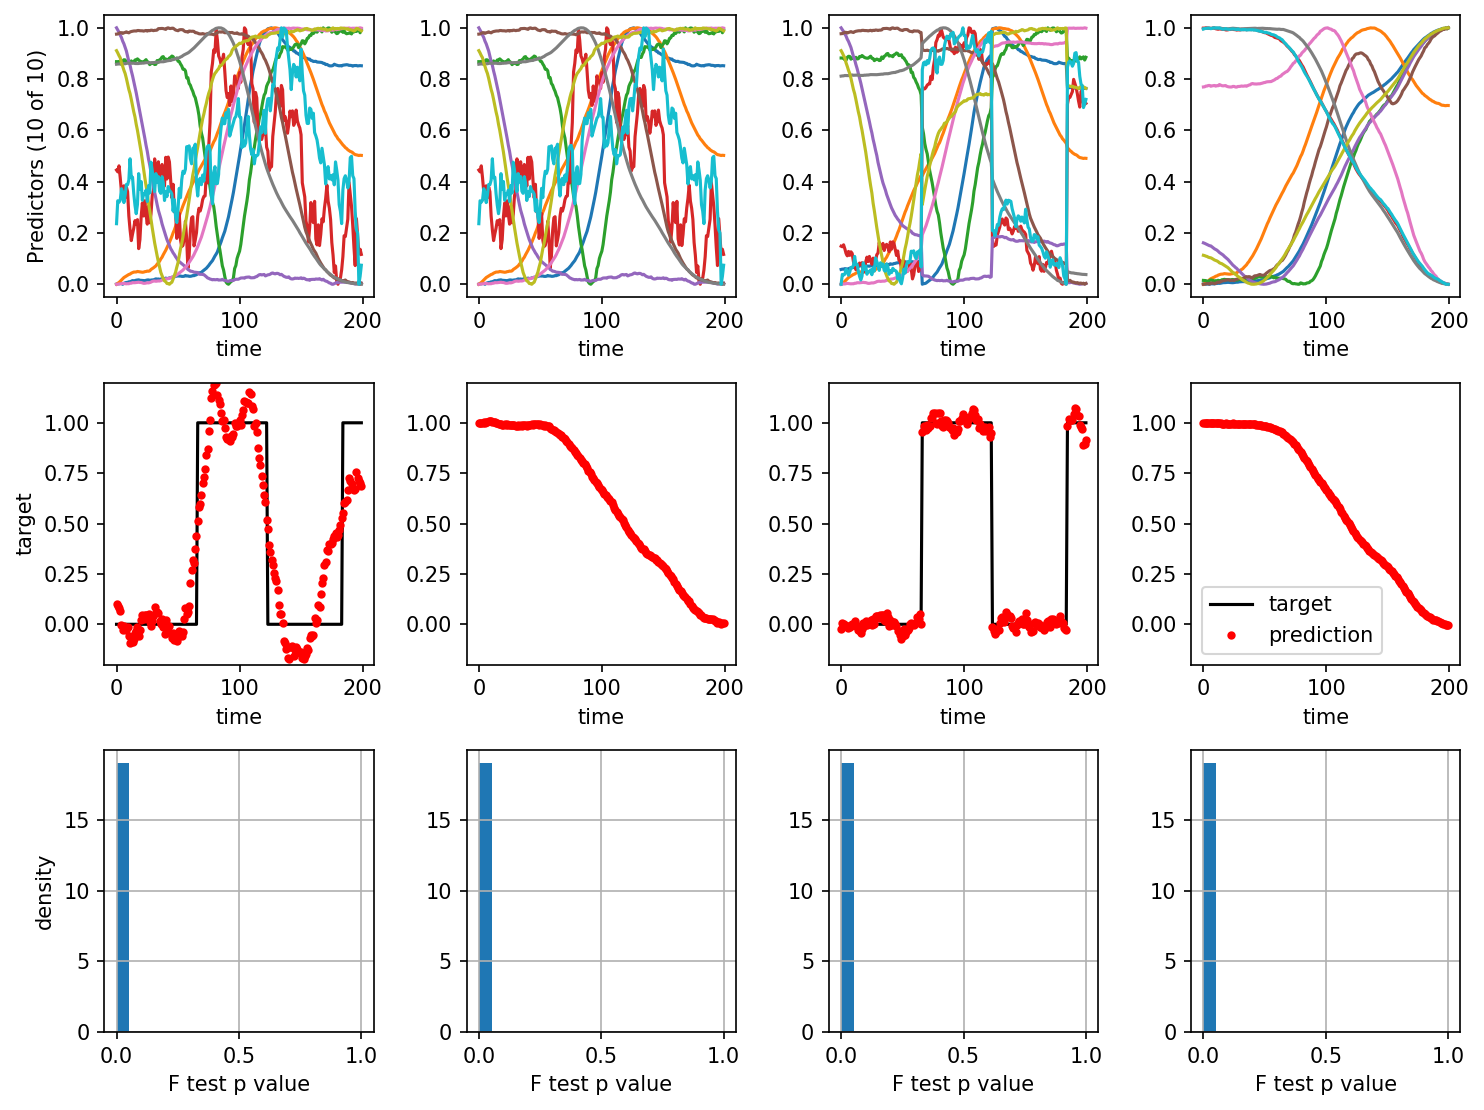

In [8]:
# p values for multiple linear regression

if 1: # make 0 to skip calculations
    p_naive = np.zeros((n_params, R))
    for i in range(n_params):
        for r in range(R):
            x, y = test_data[i][r]
            model = sm.OLS(y,np.hstack((x,np.ones((params.T, 1))))).fit()  # Ordinary Least Squares
            p_naive[i, r] = model.f_pvalue
        
fig, ax = plt.subplots(3, n_params, figsize=(10, 7.5), dpi=150)
for i in range(n_params):
    x, y = test_data[i][0]
    ax[0, i].plot(x[:, :])
    ax[1, i].plot(y, 'k')
    _, _, y_hat = ridge_error(x, y)
    ax[1, i].plot(y_hat, 'r.')
    ax[1, i].set_ylim([-.2, 1.2])
    ax[2, i].hist(p_naive[i], np.linspace(0, 1, 20), density=True)

    ax[2, i].grid()
    ax[0, i].set_xlabel('time')
    ax[1, i].set_xlabel('time')
    ax[2, i].set_xlabel('F test p value')
    
ax[0, 0].set_ylabel(f'Predictors (10 of {params.C})')
ax[1, 0].set_ylabel('target')
ax[2, 0].set_ylabel('density')
ax[1, 3].legend(('target', 'prediction'))

plt.tight_layout()
if SaveFigs: 
    plt.savefig('Ftest.png', dpi=300)

p_value = 0.762
p_value = 0.7979999999999999
p_value = 0.0
p_value = 0.522


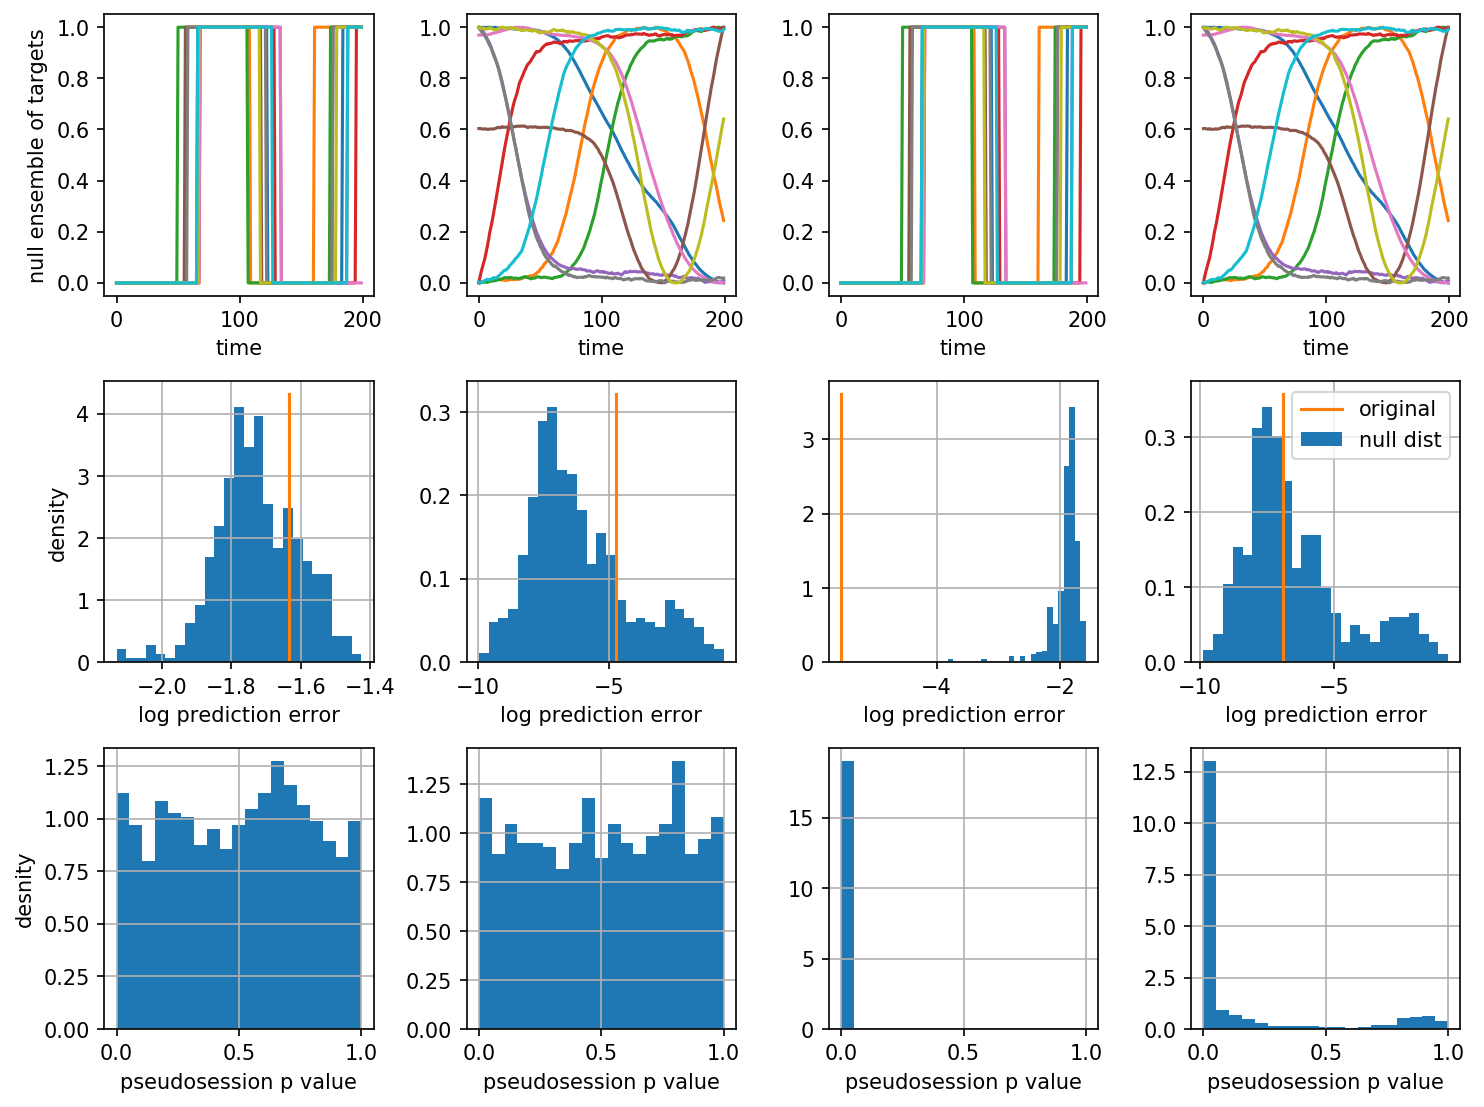

In [9]:
# pseudosession method

if 1: # make 0 to skip calculations
    p_pseudosession = np.zeros((n_params, R))
    pScore_pseud = np.zeros((n_params, N))
    uScore_pseud = np.zeros(n_params)
    for i, params in enumerate(param_list):
        np.random.seed(seed)
        for r in range(R):
            x, y = test_data[i][r]
            uScore_pseud[i], _, _ = ridge_error(x, y) # unpermuted score

            for n in range(N):
                _, y2 = make_data(params)
                pScore_pseud[i, n], _, _ = ridge_error(x, y2)
            # compare the percentile rank of uScore_pseud against the pScore_pseud array
            p_pseudosession[i, r] = stats.percentileofscore(pScore_pseud[i], uScore_pseud[i])/100  

fig, ax = plt.subplots(3, n_params, figsize=(10,7.5), dpi=150)#, sharey='row')
for i, params in enumerate(param_list):
    np.random.seed(seed)
    for n in range(10): 
        _, y2 = make_data(params)
        ax[0, i].plot(y2)
    ax[1, i].hist(np.log(pScore_pseud[i]), 25, density=True)
    ax[1, i].plot(np.full(2, np.log(uScore_pseud[i])), ax[1, i].get_ylim())
    ax[1, i].grid()

    print(f'p_value = {p_pseudosession[i, -1]}')
    ax[2, i].hist(p_pseudosession[i], np.linspace(0,1,20), density=True)
    ax[2, i].grid()
    ax[0, i].set_xlabel('time')
    ax[1, i].set_xlabel('log prediction error')
    ax[2, i].set_xlabel('pseudosession p value')
        
ax[0, 0].set_ylabel('null ensemble of targets')
ax[1, 0].set_ylabel('frequency')
ax[1, 0].set_ylabel('density')
ax[2, 0].set_ylabel('desnity')
ax[1, 3].legend(['original', 'null dist'])
    
plt.tight_layout()
if SaveFigs: plt.savefig('Pseudosession.png', dpi=300)

data set 0
data set 1
data set 2
data set 3


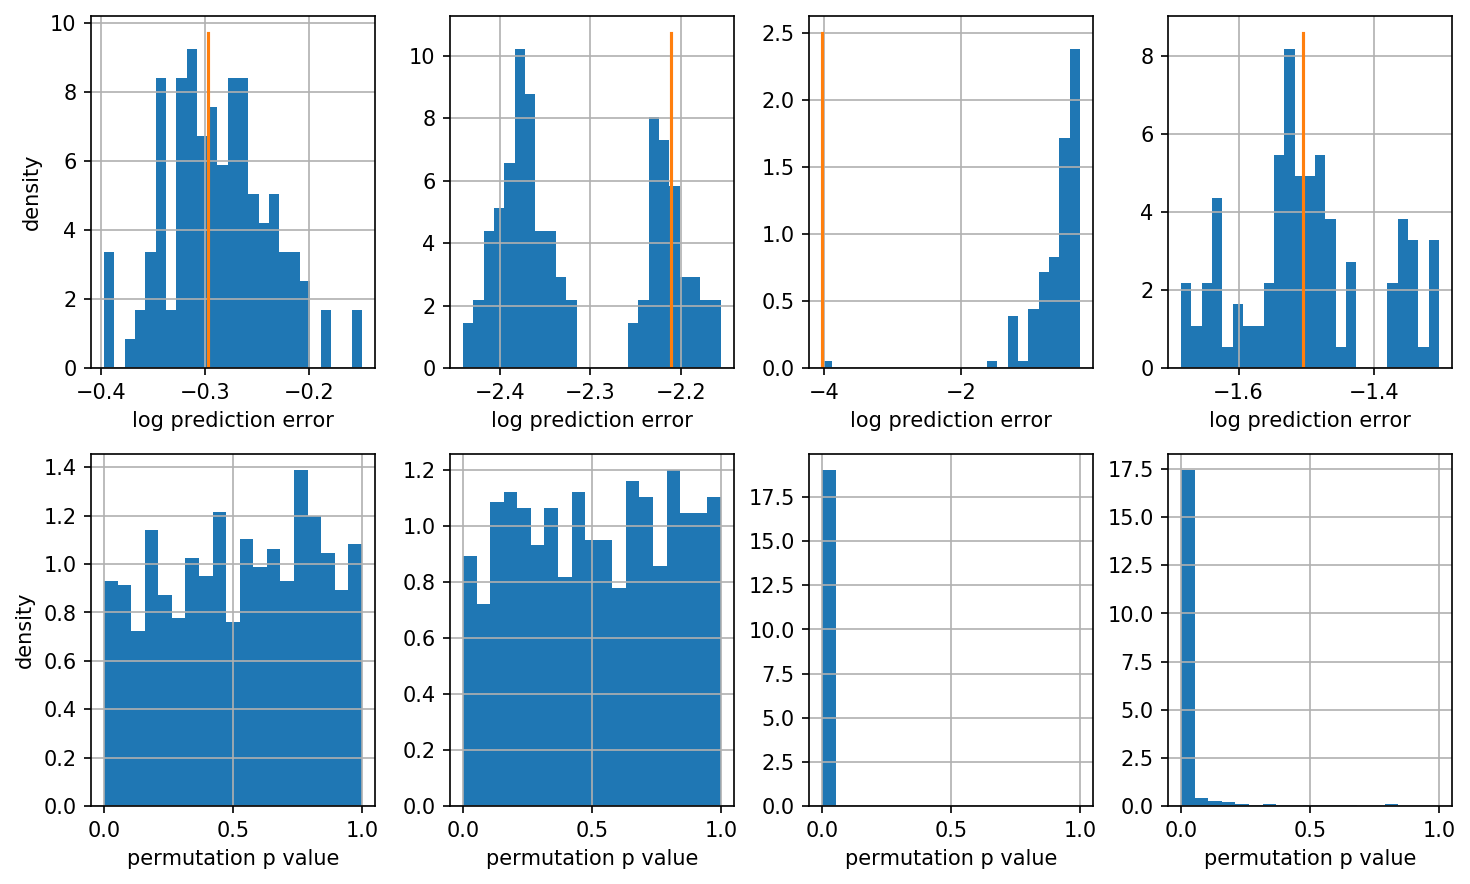

In [10]:
# Session permutation
S = 5 # number of sessions

if 1: # make 0 to skip calculations
    np.random.seed(seed)
        
    p_perm = np.zeros((n_params, R))
    uScore_perm = np.zeros(n_params)
    pScore_perm = np.zeros((n_params, np.math.factorial(S)))

    for i, params in enumerate(param_list):
        print(f'data set {i}')
        for r in range(R):
            x = np.empty(S, dtype=object)
            y = np.empty(S, dtype=object)

            uScore_perm[i] = 0
            for s in range(S):
                x[s], y[s] = make_data(params)
                sc, _, _ = ridge_error(x[s], y[s], 0)
                uScore_perm[i] += sc

            pScore_perm[i] = 0
            for j, p in enumerate(itertools.permutations(range(S))):
                for s in range(S):
                    sc, _, _ = ridge_error(x[s], y[p[s]], 0)
                    pScore_perm[i, j] += sc

            p_perm[i, r] = stats.percentileofscore(pScore_perm[i], uScore_perm[i])/100
        
fig, ax = plt.subplots(2,len(param_list), figsize=(10,6), dpi=150)
for i in range(n_params):
    ax[0, i].hist(np.log(pScore_perm[i]), 25, density=True)
    ax[0, i].plot(np.full(2,np.log(uScore_perm[i])), ax[0,i].get_ylim())
    ax[0, i].grid()
    ax[1, i].hist(p_perm[i],np.linspace(0,1,20), density=True)
    ax[1, i].grid()
    ax[0, i].set_xlabel('log prediction error')
    ax[1, i].set_xlabel('permutation p value')


ax[0, 0].set_ylabel('density')
ax[1, 0].set_ylabel('density')

plt.tight_layout()
if SaveFigs: plt.savefig('SessionPerm.png', dpi=300)